# Common Lyapunov Control Design

In [1]:
# Import packages
import numpy as np
import scipy as sp
import cvxpy as cp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import IPython.display as ipdi
import lib as lb

In [2]:
# System state-space definition
A_list = [np.array([[+1, +0.50], [-0.50, +1]])]
A_list += [np.array([[-1, -0.75], [+0.50, +1]])]
A_list += [np.array([[+1, +0.50], [-0.25, -0.5]])]
B_list = [np.array([[+1, 0.0], [0.0, +1]])]
B_list += [np.array([[+1, -0.25], [+0.25, +1]])]
B_list += [np.array([[+1, +0.50], [-0.25, -1]])]

# System dimensions
nxn = np.shape(A_list[0])
nxm = np.shape(B_list[0])
mxn = nxm[::-1]

# Weighting matrices
Q = np.identity(nxm[0])
R = np.identity(nxm[1])

# Switching sequence for simulation
#sw = [np.random.randint(3) for i in range(50)] # Equal probability for sw signal

# Higher probability of mode 0 for switching signal
p = [0.1, 0.1, 0.8]
np.random.seed(seed=3)
sw = [np.random.choice(np.arange(3), p=p) for i in range(50)]

# Initial state
x_0 = np.array([[-25], [50]])

# Matplotlib settings
ipdi.set_matplotlib_formats('svg')

## Robust state feedback gain

In [3]:
# Optimization variables
X_r = cp.Variable(shape=nxn, PSD=True)
K = cp.Variable(shape=mxn, PSD=False)

In [4]:
# Constraints
Constraints = []
for A, B in zip(A_list, B_list):
    Constraints += [cp.bmat([[X_r, (A*X_r + B*K).T, (spla.sqrtm(Q)*X_r).T, (spla.sqrtm(R)*K).T],
                            [A*X_r + B*K, X_r, np.zeros(nxn), np.zeros(nxm)],
                            [spla.sqrtm(Q)*X_r, np.zeros(nxn), np.identity(nxm[0]), np.zeros(nxm)],
                            [spla.sqrtm(R)*K, np.zeros(mxn), np.zeros(mxn), np.identity(nxm[1])]]) >> 0]
del A, B

In [5]:
# Objective function
Objective = cp.Minimize(-cp.trace(X_r))

In [6]:
# Problem formulation
Problem = cp.Problem(Objective, Constraints)
Problem.solve(solver=cp.CVXOPT, eps=1e-12, verbose=True)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.3671e+01  4e+01  1e+00  8e+00  1e+00
 1: -6.9625e-01 -1.8597e+00  3e+00  2e-01  9e-01  5e-01
 2: -7.4981e-01 -1.1699e+00  9e-01  5e-02  3e-01  1e-01
 3: -6.5924e-01 -7.7019e-01  2e-01  1e-02  7e-02  2e-02
 4: -6.3215e-01 -6.6516e-01  7e-02  4e-03  2e-02  5e-03
 5: -6.2038e-01 -6.2297e-01  6e-03  3e-04  2e-03  4e-04
 6: -6.1893e-01 -6.1932e-01  9e-04  4e-05  2e-04  4e-05
 7: -6.1873e-01 -6.1874e-01  1e-05  6e-07  3e-06  6e-07
 8: -6.1873e-01 -6.1873e-01  9e-07  5e-08  3e-07  4e-08
 9: -6.1873e-01 -6.1873e-01  7e-08  3e-09  2e-08  3e-09
Optimal solution found.


-0.6187280484955806

In [7]:
# Compute common Lyapunov solution
P_r = spla.inv(X_r.value)
print("The common robust Lyapunov P_r is equal to: \n {}".format(P_r))

The common robust Lyapunov P_r is equal to: 
 [[5.06360358 2.1981904 ]
 [2.1981904  3.77559644]]


In [8]:
# Compute the eigenvalues of P_r
(eig_r, vec_r) = spla.eig(P_r)
print("The eigenvalues of P_r are equal to: \n {}".format(eig_r))

The eigenvalues of P_r are equal to: 
 [6.71018544+0.j 2.12901458+0.j]


In [9]:
# Compute robust state feedback gain
F_r = K.value @ P_r
print("The robust feedback gain F_r is equal to: \n {}".format(F_r))

The robust feedback gain F_r is equal to: 
 [[-0.02334124  0.09249872]
 [-0.36125887 -1.02091536]]


In [10]:
# Simulation test for robust control law
x_r = np.hstack((x_0, np.zeros((2, len(sw)))))
u_r = np.zeros((2, len(sw)))
J_r = 0
for k, s in enumerate(sw):
    u_r[:,k] = F_r @ x_r[:,k]
    x_r[:,k+1] = A_list[s] @ x_r[:,k] + B_list[s] @ u_r[:,k]
    J_r += x_r[:,k].T @ Q @ x_r[:,k].T + u_r[:,k].T @ R @ u_r[:,k]
del k, s

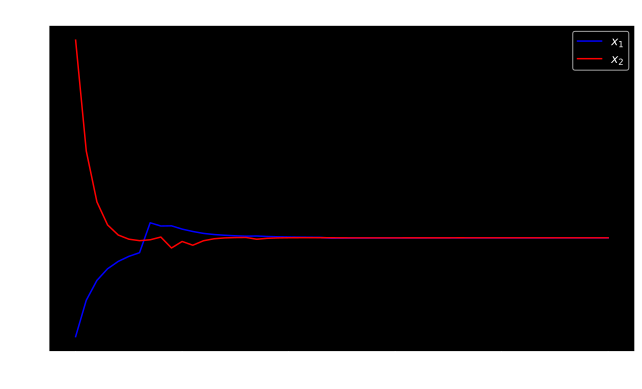

The robust control cost is equal to: 
 6381.630283595386


In [11]:
# Generate plot and display control cost
fig_r = plt.figure(figsize=(10.5,6))
plt.style.use('dark_background')
plt.plot(range(len(sw) + 1), x_r[0,:], 'b', range(len(sw) + 1), x_r[1,:], 'r')
plt.title('System states with robust control', fontsize=16, fontweight='bold')
plt.xlabel('Time steps')
plt.ylabel('States')
plt.legend(('$x_{1}$', '$x_{2}$'), fontsize=12)
plt.show()
print("The robust control cost is equal to: \n {}".format(J_r))

## Common Lyapunov state feedback gains

In [12]:
# Optimization variables
X_c = cp.Variable(shape=nxn, PSD=True)
K_list = [cp.Variable(shape=mxn, PSD=False) for i in range(len(B_list))]

In [13]:
# Constraints
Constraints = []
for A, B, K in zip(A_list, B_list, K_list):
    Constraints += [cp.bmat([[X_c, (A*X_c + B*K).T, (spla.sqrtm(Q)*X_c).T, (spla.sqrtm(R)*K).T],
                            [A*X_c + B*K, X_c, np.zeros(nxn), np.zeros(nxm)],
                            [spla.sqrtm(Q)*X_c, np.zeros(nxn), np.identity(nxm[0]), np.zeros(nxm)],
                            [spla.sqrtm(R)*K, np.zeros(mxn), np.zeros(mxn), np.identity(nxm[1])]]) >> 0]
del A, B, K

In [14]:
# Objective function
Objective = cp.Minimize(-cp.trace(X_c))

In [15]:
# Problem formulation
Problem = cp.Problem(Objective, Constraints)
Problem.solve(solver=cp.CVXOPT, eps=1e-12, verbose=True)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.3623e+01  4e+01  1e+00  8e+00  1e+00
 1: -8.3791e-01 -1.4386e+00  1e+00  1e-01  6e-01  4e-01
 2: -9.7889e-01 -1.1678e+00  4e-01  3e-02  1e-01  7e-02
 3: -9.2193e-01 -9.4066e-01  3e-02  2e-03  1e-02  2e-03
 4: -9.2286e-01 -9.2419e-01  2e-03  2e-04  8e-04  2e-04
 5: -9.2270e-01 -9.2289e-01  3e-04  2e-05  1e-04  2e-05
 6: -9.2268e-01 -9.2268e-01  1e-05  6e-07  3e-06  5e-07
 7: -9.2268e-01 -9.2268e-01  6e-07  4e-08  2e-07  3e-08
 8: -9.2268e-01 -9.2268e-01  6e-08  4e-09  2e-08  3e-09
Optimal solution found.


-0.9226772708569867

In [16]:
# Compute common Lyapunov solution
P_c = spla.inv(X_c.value)
print("The common Lyapunov P_c is equal to: \n {}".format(P_c))

The common Lyapunov P_c is equal to: 
 [[2.19253472 0.41015819]
 [0.41015819 2.29496774]]


In [17]:
# Compute the eigenvalues of P_c
(eig_c, vec_c) = spla.eig(P_c)
print("The eigenvalues of P_c are equal to: \n {}".format(eig_c))

The eigenvalues of P_c are equal to: 
 [1.8304077 +0.j 2.65709476+0.j]


In [18]:
# Compute the state feedback gains
F_clist = [K.value @ P_c for K in K_list]
[print("The feedback gain F{} is equal to: \n {} \n".format(i, F)) for i, F in enumerate(F_clist)];

The feedback gain F0 is equal to: 
 [[-0.65273458 -0.37115464]
 [ 0.28240447 -0.73567998]] 

The feedback gain F1 is equal to: 
 [[ 0.56020503  0.29637344]
 [-0.46124339 -0.74246213]] 

The feedback gain F2 is equal to: 
 [[-0.61054532 -0.22964666]
 [-0.13454613 -0.31514848]] 



In [19]:
# Simulation test for common design Lyapunov control laws
x_c = np.hstack((x_0, np.zeros((2, len(sw)))))
u_c = np.zeros((2, len(sw)))
J_c = 0
for k, s in enumerate(sw):
    u_c[:,k] = F_clist[s] @ x_c[:,k]
    x_c[:,k+1] = A_list[s] @ x_c[:,k] + B_list[s] @ u_c[:,k]
    J_c += x_c[:,k].T @ Q @ x_c[:,k].T + u_c[:,k].T @ R @ u_c[:,k]
del k, s

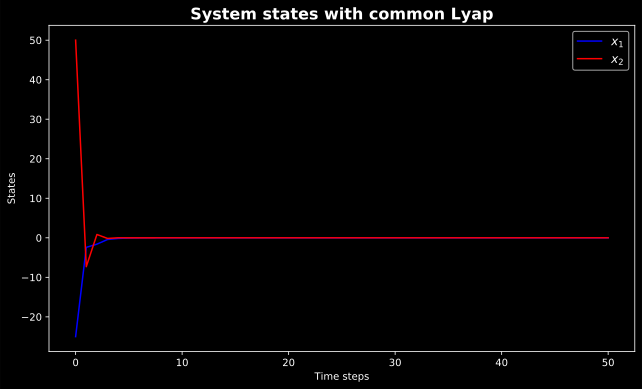

The common Lyapunov control cost is equal to: 
 3373.1125374706908


In [20]:
# Generate plot and display control cost
fig_c = plt.figure(figsize=(10.5,6))
plt.style.use('dark_background')
plt.plot(range(len(sw) + 1), x_c[0,:], 'b', range(len(sw) + 1), x_c[1,:], 'r')
plt.title('System states with common Lyap', fontsize=16, fontweight='bold')
plt.xlabel('Time steps')
plt.ylabel('States')
plt.legend(('$x_{1}$', '$x_{2}$'), fontsize=12)
plt.show()
print("The common Lyapunov control cost is equal to: \n {}".format(J_c))

## Switching state feedback gain with own Lyapunov functions

In [21]:
# Optimization variables
X_e = cp.Variable(shape=nxn, PSD=True)
X_list = [cp.Variable(shape=nxn, PSD=True) for i in range(len(A_list))]
K_list = [cp.Variable(shape=mxn, PSD=False) for i in range(len(B_list))]

In [22]:
# Constraints
Constraints = []
for A, B, K, X in zip(A_list, B_list, K_list, X_list):
    Constraints += [cp.bmat([[X, (A*X + B*K).T, (spla.sqrtm(Q)*X).T, (spla.sqrtm(R)*K).T],
                            [A*X + B*K, X, np.zeros(nxn), np.zeros(nxm)],
                            [spla.sqrtm(Q)*X, np.zeros(nxn), np.identity(nxm[0]), np.zeros(nxm)],
                            [spla.sqrtm(R)*K, np.zeros(mxn), np.zeros(mxn), np.identity(nxm[1])]]) >> 0]
del A, B, K, X

In [23]:
# Constraints for switching stability
for A, B, K, X in zip(A_list, B_list, K_list, X_list):
    Constraints += [cp.bmat([[X, (A*X + B*K).T],
                            [(A*X + B*K), X_e]]) >> 0, X >> X_e]
del A, B, K, X

In [24]:
# Objective function
Sum = sum(w*X for w, X in zip(p, X_list))
Objective = cp.Minimize(-cp.trace(Sum))

In [25]:
# Problem formulation
Problem = cp.Problem(Objective, Constraints)
Problem.solve(solver=cp.CVXOPT, eps=1e-12, verbose=True)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.4277e+01  7e+01  2e+00  1e+01  1e+00
 1: -1.1482e+00 -3.2956e+00  7e+00  3e-01  2e+00  4e-01
 2: -1.5635e+00 -2.5338e+00  3e+00  2e-01  1e+00  2e-01
 3: -1.4475e+00 -1.8120e+00  1e+00  6e-02  3e-01  5e-02
 4: -1.4670e+00 -1.5190e+00  2e-01  8e-03  5e-02  8e-03
 5: -1.4701e+00 -1.4926e+00  7e-02  3e-03  2e-02  3e-03
 6: -1.4728e+00 -1.4773e+00  1e-02  7e-04  4e-03  5e-04
 7: -1.4728e+00 -1.4745e+00  5e-03  2e-04  2e-03  2e-04
 8: -1.4729e+00 -1.4733e+00  1e-03  5e-05  3e-04  3e-05
 9: -1.4729e+00 -1.4730e+00  3e-04  1e-05  8e-05  7e-06
10: -1.4729e+00 -1.4729e+00  5e-05  2e-06  1e-05  1e-06
11: -1.4729e+00 -1.4729e+00  8e-06  4e-07  2e-06  2e-07
12: -1.4729e+00 -1.4729e+00  3e-07  2e-08  1e-07  8e-09
13: -1.4729e+00 -1.4729e+00  5e-08  2e-09  1e-08  1e-09
Optimal solution found.


-1.4729257300104859

In [26]:
# Compute Common Lyapunov solution
P_e = spla.inv(X_e.value)
print("The common Lyapunov P_e is equal to: \n {}".format(P_e))

The common Lyapunov P_e is equal to: 
 [[2.84782037 0.53602904]
 [0.53602904 2.93599362]]


In [27]:
# Compute the eigenvalues of P_e
(eig_e, vec_e) = spla.eig(P_e)
print("The eigenvalues of P_e are equal to: \n {}".format(eig_e))

The eigenvalues of P_e are equal to: 
 [2.35406803+0.j 3.42974597+0.j]


In [28]:
# Compute the individual Lyapunov function
P_list = [spla.inv(X.value) for X in X_list]
[print("The Lyapunov function P{} is equal to: \n {} \n".format(i, P)) for i, P in enumerate(P_list)];

The Lyapunov function P0 is equal to: 
 [[1.80424767e+00 2.01664582e-10]
 [2.01664582e-10 1.80424767e+00]] 

The Lyapunov function P1 is equal to: 
 [[1.64721086 0.62158901]
 [0.62158901 1.80260812]] 

The Lyapunov function P2 is equal to: 
 [[1.5509579  0.22459639]
 [0.22459639 1.1785514 ]] 



In [29]:
# Compute the eigenvalues of P_list
eig_list = [spla.eig(P) for P in P_list]
[print("The eigenvalues of P{} are equal to: \n {} \n".format(i, eig[0])) for i, eig in enumerate(eig_list)];

The eigenvalues of P0 are equal to: 
 [1.80424767+0.j 1.80424767+0.j] 

The eigenvalues of P1 are equal to: 
 [1.09848313+0.j 2.35133584+0.j] 

The eigenvalues of P2 are equal to: 
 [1.65649972+0.j 1.07300957+0.j] 



In [30]:
# Compute the state feedback gains
F_elist = [K.value @ P for K, P in zip(K_list, P_list)]
[print("The feedback gain F{} is equal to: \n {} \n".format(i, F)) for i, F in enumerate(F_elist)];

The feedback gain F0 is equal to: 
 [[-0.64339663 -0.321698  ]
 [ 0.32169847 -0.64339621]] 

The feedback gain F1 is equal to: 
 [[ 0.48379143  0.21788702]
 [-0.3524527  -0.62637635]] 

The feedback gain F2 is equal to: 
 [[-0.55095687 -0.22459713]
 [-0.15674472 -0.26690342]] 



In [31]:
# Simulation test for common Lyapunov control laws
x_e = np.hstack((x_0, np.zeros((2, len(sw)))))
u_e = np.zeros((2, len(sw)))
J_e = 0
for k, s in enumerate(sw):
    u_e[:,k] = F_elist[s] @ x_e[:,k]
    x_e[:,k+1] = A_list[s] @ x_e[:,k] + B_list[s] @ u_e[:,k]
    J_e += x_e[:,k].T @ Q @ x_e[:,k].T + u_e[:,k].T @ R @ u_e[:,k]
del k, s

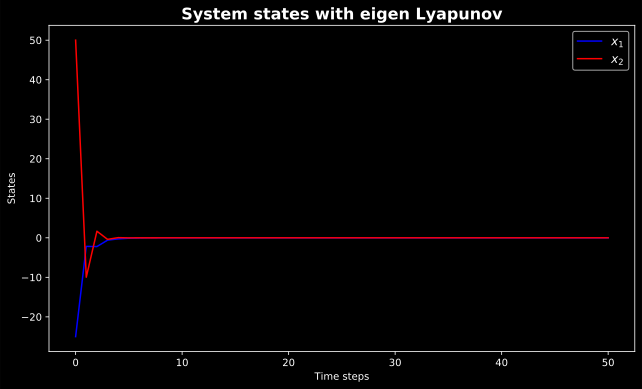

The common Lyapunov control cost is equal to: 
 3354.236400619564


In [32]:
# Generate plot and display control cost
fig_e = plt.figure(figsize=(10.5,6))
plt.style.use('dark_background')
plt.plot(range(len(sw) + 1), x_e[0,:], 'b', range(len(sw) + 1), x_e[1,:], 'r')
plt.title('System states with eigen Lyapunov', fontsize=16, fontweight='bold')
plt.xlabel('Time steps')
plt.ylabel('States')
plt.legend(('$x_{1}$', '$x_{2}$'), fontsize=12)
plt.show()
print("The common Lyapunov control cost is equal to: \n {}".format(J_e))

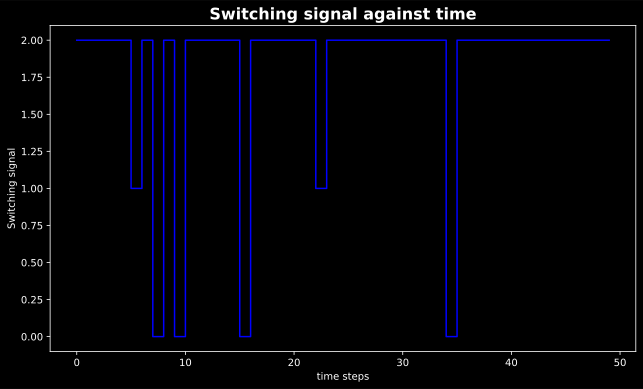

In [33]:
# Switching signal
fig_sw = plt.figure(figsize=(10.5,6))
plt.style.use('dark_background')
plt.step(range(len(sw)), sw, 'b')
plt.title('Switching signal against time', fontsize=16, fontweight='bold')
plt.xlabel('time steps')
plt.ylabel('Switching signal')
plt.show()

In [34]:
# Data save in .dat format for LateX and TikZ plots
# np.savetxt('dat/x_data.dat', x_co.T, fmt='%1.6f', delimiter=',')

## Comparison of Lyapunov functions and costs

In [35]:
# Robust case scenario
print(eig_r)
print("Weighted sum of eigenvalues in robust case is {}".format(np.real(np.sum(eig_r))))

[6.71018544+0.j 2.12901458+0.j]
Weighted sum of eigenvalues in robust case is 8.839200018081502


In [36]:
# Common case scenario
print(eig_c)
print("Weighted sum of eigenvalues in common case is {}".format(np.real(np.sum(eig_c))))

[1.8304077 +0.j 2.65709476+0.j]
Weighted sum of eigenvalues in common case is 4.48750246149722


In [37]:
# Eigen case scenario
print(eig_e)
S = 0
for i, e in enumerate(eig_list):
    S += e[0] * p[i]
del i, e
print("Sum S of weighted eigenvalues is equal to {} and {}".format(np.real(S[0]), np.real(S[1])))
print("Weighted sum of eigenvalues in single case is {}".format(np.real(np.sum(S))))

[2.35406803+0.j 3.42974597+0.j]
Sum S of weighted eigenvalues is equal to 1.615472857855755 and 1.2739660056588376
Weighted sum of eigenvalues in single case is 2.8894388635145924


In [38]:
# Computation of Lyapunov costs for the robust, common and eigen case scenarios
V_r = np.zeros(len(sw)) # Initialization robust Lyap cost
V_c = np.zeros(len(sw)) # Initialization common Lyap cost
V_e = np.zeros(len(sw)) # Initialization eigen Lyap cost
for k, s in enumerate(sw):
    V_r[k] = x_r[:,k].T @ P_r @ x_r[:,k]
    V_c[k] = x_c[:,k].T @ P_c @ x_c[:,k]
    V_e[k] = x_e[:,k].T @ P_list[s] @ x_e[:,k]
del k, s

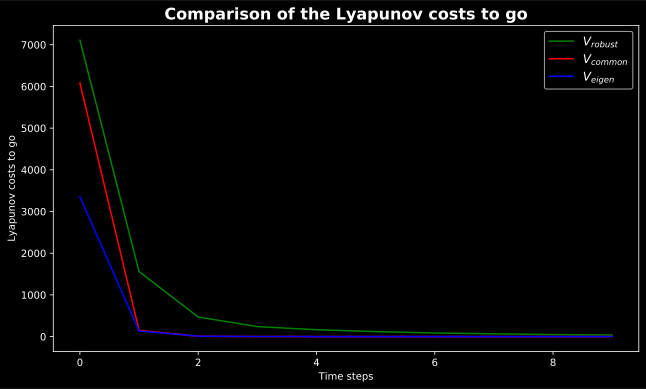

In [39]:
# Plot of Lyapunov cost evolution
fig_co = plt.figure(figsize=(10.5,6))
plt.style.use('dark_background')
plt.plot(range(10), V_r[range(10)], 'g', range(10), V_c[range(10)], 'r', range(10), V_e[range(10)], 'b')
plt.title('Comparison of the Lyapunov costs to go', fontsize=16, fontweight='bold')
plt.xlabel('Time steps')
plt.ylabel('Lyapunov costs to go')
plt.legend(('$V_{robust}$', '$V_{common}$', '$V_{eigen}$'), fontsize=12)
plt.show()

In [40]:
# Data save in .dat format for LateX and TikZ plots
np.savetxt('dat/V_data.dat', np.c_[V_r, V_c, V_e], fmt='%1.6f', delimiter=',')